#################################################### Importing Libraries ####################################################

In [1]:
!pip install import_ipynb
!pip install -U -q PyDrive
!pip install pytorch_pretrained_bert
!pip install sparse
!pip install transformers
!pip install torchmetrics
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
2.1.0

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip

In [2]:
!pip install einops


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.

import torch
from torch_geometric.data import Data

import numpy as np
import sparse

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as tgmnn
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataListLoader as GraphLoader
from torch_geometric.data import Batch

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import time
from sklearn import preprocessing
import math
from torch.utils.data import Dataset
import copy
import sklearn.metrics as skm
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
import pytorch_pretrained_bert as Bert
import itertools
from einops import rearrange, repeat

import ast
from typing import Optional, Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptTensor, PairTensor, SparseTensor
from torch_geometric.utils import softmax
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import LayerNorm
import torch.nn.functional as F
from torch import Tensor

from sklearn.model_selection import ShuffleSplit
import pickle
from matplotlib import pyplot as plt
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

/Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch_geometric/typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN5torch8autograd13_wrap_outputsERKNSt3__16vectorIN2at6TensorENS1_9allocatorIS4_EEEERKNS1_13unordered_setIPN3c1010TensorImplENS1_4hashISD_EENS1_8equal_toISD_EENS5_ISD_EEEESL_NSB_8ArrayRefINSB_8optionalIS4_EEEERKNS1_10shared_ptrINS0_4NodeEEENS1_8functionIFS7_S7_S7_EEE
  Referenced from: <BEF9F452-9D77-323E-91B8-AF667F303838> /Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <66FB8649-BB87-3CD6-A177-462038DCAE02> /Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue 

In [4]:
# if you are using a mac this cell aims to solve this error: 
# NotImplementedError: The operator 'aten::scatter_reduce.two_out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable ⁠ PYTORCH_ENABLE_MPS_FALLBACK=1 ⁠ to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

# You will probably need first to execute this bash command in your terminal: touch .zshenv && echo 'export PYTORCH_ENABLE_MPS_FALLBACK=1' >> .zshenv
# And then restart the notebook

#import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

#################################################### Start tensorboard ####################################################

In [5]:
# %load_ext tensorboard
# %reload_ext tensorboard
# # %tensorboard --logdir $log_dir --port 6006

#################################################### Defining classes ####################################################

In [6]:
#######################################################################################################################################
###################################################### Transformer Conv ###############################################################
#######################################################################################################################################

class TransformerConv(MessagePassing):
    _alpha: OptTensor
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.beta = beta and root_weight
        self.root_weight = root_weight
        self.concat = concat
        self.dropout = dropout
        self.edge_dim = edge_dim
        self._alpha = None

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_key = Linear(in_channels[0], heads * out_channels)
        self.lin_query = Linear(in_channels[1], heads * out_channels)
        self.lin_value = Linear(in_channels[0], heads * out_channels)
        self.layernorm1 = LayerNorm(out_channels)
        self.layernorm2 = LayerNorm(out_channels)
        self.gelu = nn.GELU()
        self.proj = Linear(heads * out_channels, out_channels)
        self.ffn = Linear(out_channels, out_channels)
        self.ffn2 = Linear(out_channels, out_channels)
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.lin_edge = self.register_parameter('lin_edge', None)


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim:
            self.lin_edge.reset_parameters()


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, batch=None, return_attention_weights=None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""Runs the forward pass of the module.

        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        residual = x
        x = self.layernorm1(x, batch)
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        query = self.lin_query(x[1]).view(-1, H, C)
        key = self.lin_key(x[0]).view(-1, H, C)
        value = self.lin_value(x[0]).view(-1, H, C)
        # propagate_type: (query: Tensor, key:Tensor, value: Tensor, edge_attr: OptTensor) # noqa
        out = self.propagate(edge_index, query=query, key=key, value=value,
                             edge_attr=edge_attr, size=None)
        alpha = self._alpha
        self._alpha = None
        if self.concat:
            out = self.proj(out.view(-1, self.heads * self.out_channels))
        else:
            out = out.mean(dim=1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out+residual
        residual = out

        out = self.layernorm2(out)
        out = self.gelu(self.ffn(out))
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.ffn2(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out + residual
        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, query_i: Tensor, key_j: Tensor, value_j: Tensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:


        if self.lin_edge is not None:
            assert edge_attr is not None
            edge_attr = self.lin_edge(edge_attr).view(-1, self.heads,
                                                      self.out_channels)
            key_j = key_j + edge_attr

        alpha = (query_i * key_j).sum(dim=-1) / math.sqrt(self.out_channels)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        out = value_j
        if edge_attr is not None:
            out = out + edge_attr

        out = out * alpha.view(-1, self.heads, 1)
        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

In [7]:
#######################################################################################################################################
###################################################### Graph Transformer ###############################################################
#######################################################################################################################################

class GraphTransformer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.transformerconv1 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv2 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv3 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=False)
        
        self.embed = nn.Embedding(config.vocab_size, config.hidden_size // 5) 
        self.embed_ee = nn.Embedding(config.node_attr_size, config.hidden_size // 5)
                    

    def forward(self, x, edge_index, edge_index_readout, edge_attr, batch):
        #print("GT")
        indices = (x==0).nonzero().squeeze()
        h_nodes = self.transformerconv1(x=self.embed(x), edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv2(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv3(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        x = h_nodes[indices]
        return x, h_nodes

In [8]:
#######################################################################################################################################
######################################################## Bert Config ##################################################################
#######################################################################################################################################

class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.age_vocab_size = config.get('age_vocab_size')
        self.type_vocab_size = config.get('type_vocab_size')
        self.time_vocab_size = config.get('time_vocab_size')
        self.graph_dropout_prob = config.get('graph_dropout_prob')
        self.node_attr_size = config.get('node_attr_size')
        

In [9]:
class Pre_training_1(nn.Module):
    def __init__(self, config):
        super(Pre_training_1, self).__init__()
        self.config = config
        self.gnn = GraphTransformer(config)
        self.linear = nn.Linear(self.config.hidden_size // 5, self.config.vocab_size)
        self.layers = nn.ModuleList([self.gnn, self.linear])

    def forward(self, nodes, edge_index, edge_index_readout, edge_attr, batch):
        # Define the forward pass using self.gnn and self.linear as needed
        vst,x = self.gnn(nodes, edge_index, edge_index_readout, edge_attr, batch)
        x = self.linear(x)
        return x

In [10]:
#######################################################################################################################################
############################################################ GDSet ####################################################################
#######################################################################################################################################

class GDSet(Dataset):
    def __init__(self, g):
        self.g = g

    def __getitem__(self, index):

        g = self.g[index]
        for i in range(len(g)):
          g[i]['posi_ids'] = i
        return g

    def __len__(self):
        return len(self.g)

#################################################### Importing Data ######################################################

In [11]:
path = '../../data/'
path_results = '../../results/'

In [12]:
with open(path + 'data_pad100.pkl', 'rb') as handle:
    dataset = pickle.load(handle)

##################################################### Splitting Data ######################################################

In [13]:
#######################################################################################################################################
pourcentage_nodes_to_mask = 0.15
labels_masked_nodes = []
mask_node_embeddings = 2

In [14]:
def split_dataset(dataset, train_params, random_seed=1):
  rs = ShuffleSplit(n_splits=1, test_size=train_params.get('test_split'), random_state=random_seed)

  for i, (train_index_tmp, test_index) in enumerate(rs.split(dataset)):
    rs2 = ShuffleSplit(n_splits=1, test_size=train_params.get('val_split'), random_state=random_seed)
    
    for j, (train_index, val_index) in enumerate(rs2.split(train_index_tmp)):
      train_index = train_index_tmp[train_index]
      val_index = train_index_tmp[val_index]
      trainDSet = [dataset[x] for x in train_index]
      valDSet = [dataset[x] for x in val_index]
      testDSet = [dataset[x] for x in test_index]

      return trainDSet, valDSet, testDSet

###################################################### Config Files ######################################################

In [15]:
train_params = {
    'batch_size': 5,
    'max_len_seq': 50,
    'device': "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"),
    #'device': "cpu",
    'data_len' : len(dataset),
    'val_split' : 0.1,
    'test_split' : 0.2,
    'train_data_len' : int(0.9*0.8*len(dataset)),   # the train dataset is 90% of 80% of the whole dataset
    'val_data_len' : int(0.1*0.8*len(dataset)),   # the validation dataset is 10% of 80% of the whole dataset
    'test_data_len' : int(0.2*len(dataset)),   # the test dataset is 20% of the whole dataset
    'epochs' : 15,
    'lr': 0.0001,
    'weight_decay': 0.0001
}

model_config = {
    'vocab_size': 9405, # number of disease + symbols for word embedding (avec vst) + 1 for mask
    'edge_relationship_size': 8, # number of vocab for edge_attr
    'hidden_size': 50*5, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': 151, # number of vocab for age embedding
    'time_vocab_size': 380, # number of vocab for time embedding
    'type_vocab_size': 11+1, # number of vocab for type embedding + 1 for mask
    'node_attr_size': 8, # number of vocab for node_attr embedding
    'num_labels':1,
    'max_position_embedding': 50, # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'graph_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 2, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'n_layers' : 3 - 1,
    'alpha' : 0.1
}

######################################################## DEVICE ##########################################################

In [16]:
# print which device is used
print('device: ', train_params['device'])

device:  mps


#################################################### Training Functions ####################################################

In [18]:
def train(model, optim, trainload, device, writer, epoch):
    tr_loss = 0
    start = time.time()
    model.train()
    
    CE_loss = torch.nn.CrossEntropyLoss(ignore_index=3)
    
    for step, data in tqdm(enumerate(trainload)):
        optim.zero_grad()

        batched_data = Batch()
        graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
        graph_batch = graph_batch.to(device)
        nodes = graph_batch.x
                
        list_index = [i for i in range(nodes.shape[0])]
        random.shuffle(list_index)
        index_nodes_to_mask = list_index[:int((nodes.shape[0]) * pourcentage_nodes_to_mask)]
        index_nodes_not_masked = list(set(list_index) - set(index_nodes_to_mask))
        labels_nodes = nodes
        ytrue = nodes

        labels_nodes[index_nodes_not_masked] = 3
        nodes[index_nodes_to_mask] = mask_node_embeddings
        
        edge_index = graph_batch.edge_index
        edge_index_readout = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        batch = graph_batch.batch

        pred = model(nodes, edge_index, edge_index_readout, edge_attr, batch)
        
        loss = CE_loss(pred, labels_nodes)
        # Update TensorBoard for train loss per iteration
        writer.add_scalar('Train Loss per Iteration', loss.item(), epoch * len(trainload) + step)
        
        loss.backward()
        tr_loss += loss.item()
        optim.step()

        del loss

    print("TOTAL TRAIN LOSS", (tr_loss * train_params['batch_size']) / len(trainload))
    cost = time.time() - start
    
    # Update TensorBoard for total train loss per epoch
    writer.add_scalar('Total Train Loss per Epoch', (tr_loss * train_params['batch_size']) / len(trainload), epoch)
    
    return tr_loss, cost, pred,ytrue

In [19]:
def eval(model, _valload, device, writer, epoch):
    tr_loss = 0
    start = time.time()
    model.eval()
    CE_loss = torch.nn.CrossEntropyLoss(ignore_index=3)
    
    with torch.no_grad():
        for step, data in tqdm(enumerate(_valload)):
            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
                    
            list_index = [i for i in range(nodes.shape[0])]
            random.shuffle(list_index)
            index_nodes_to_mask = list_index[:int((nodes.shape[0]) * pourcentage_nodes_to_mask)]
            index_nodes_not_masked = list(set(list_index) - set(index_nodes_to_mask))
            labels_nodes = nodes
            ytrue = nodes
            
            labels_nodes[index_nodes_not_masked] = 3
            nodes[index_nodes_to_mask] = mask_node_embeddings
            
            edge_index = graph_batch.edge_index
            edge_index_readout = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch

            pred = model(nodes, edge_index, edge_index_readout, edge_attr, batch)

            loss = CE_loss(pred, labels_nodes)
            # Update TensorBoard for eval loss per iteration
            writer.add_scalar('Eval Loss per Iteration', loss.item(), epoch * len(_valload) + step)
            
            tr_loss += loss.item()
            
            del loss

    print("TOTAL EVAL LOSS", (tr_loss * train_params['batch_size']) / len(_valload))
    
    # Update TensorBoard for total eval loss per epoch
    writer.add_scalar('Total Eval Loss per Epoch', (tr_loss * train_params['batch_size']) / len(_valload), epoch)
    
    cost = time.time() - start
    return tr_loss, cost, pred, ytrue

In [20]:
def run_epoch(model, optim_model, trainload, valload, device, exp, writer):
    best_val = math.inf
    loss_train_liste = []
    loss_val_liste = []
    
    for e in tqdm(range(train_params["epochs"])):
        print("Epoch n" + str(e))
        train_loss, train_time_cost, pred_train, ytrue_train = train(model, optim_model, trainload, device, writer, e)
        val_loss, val_time_cost, pred_eval, ytrue_eval = eval(model, valload, device, writer, e)
        accuracy_train = skm.accuracy_score(ytrue_train.cpu().detach().numpy(), pred_train.cpu().detach().numpy().argmax(axis=1))
        accuracy_eval = skm.accuracy_score(ytrue_eval.cpu().detach().numpy(), pred_eval.cpu().detach().numpy().argmax(axis=1))

        train_loss = (train_loss * train_params['batch_size']) / len(trainload)
        val_loss = (val_loss * train_params['batch_size']) / len(valload)
        loss_train_liste.append(train_loss)
        loss_val_liste.append(val_loss)
        print('TRAIN \t{} secs'.format(train_time_cost))
        print(f'TRAIN accuracy : {accuracy_train}')
        
        with open(path_results + 'losses_and_times/' + "pre_training_1_log_train_" + f'{exp}' + ".txt", 'a') as f:
            f.write("Epoch n" + str(e) + '\n TRAIN {}\t{} secs\n'.format(train_loss, train_time_cost))
            f.write('EVAL {}\t{} secs\n'.format(val_loss, val_time_cost) + '\n\n\n')
        print('EVAL \t{} secs'.format(val_time_cost))
        print('EVAL accuracy : {}\n\n'.format(accuracy_eval))

        if val_loss < best_val:
            print("** ** * Saving fine - tuned model ** ** * ")
            torch.save(model.gnn.state_dict(), path_results + 'weights/' + 'GraphTransformer_pretrain_1_num_' + f'{exp}' + '.pch')
            best_val = val_loss
            
    epoch = [i for i in range(train_params["epochs"])]
    plt.plot(epoch, loss_train_liste)
    plt.legend(['train'])
    plt.plot(epoch,loss_val_liste)
    plt.legend(['val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(path_results + 'plots/' + 'Pre_training_1.png')
    plt.show()

    return train_loss, val_loss, accuracy_train, accuracy_eval, train_time_cost, val_time_cost

################################################### Experiences ####################################################

In [21]:
def experiment(num_experiments=5):
    conf = BertConfig(model_config)
    df = pd.DataFrame(columns=['Experiment', 'Model', 'Metric', 'Score'])

    for exp in tqdm(range(num_experiments)):
        model = Pre_training_1(conf).to(train_params['device'])
        transformer_vars = [i for i in model.parameters()]
        optim_model = torch.optim.AdamW(transformer_vars, lr=train_params['lr'], weight_decay=train_params['weight_decay'])

        # Set log directory for TensorBoard
        writer = SummaryWriter(path_results + 'runs/' + 'pre_training_1/' + str(exp + 1))


        print(f"\n Experiment {exp + 1}")
        trainDSet, valDSet, testDSet = split_dataset(dataset, train_params, random_seed=exp)
        trainload = GraphLoader(GDSet(trainDSet), batch_size=train_params['batch_size'], shuffle=False)
        valload = GraphLoader(GDSet(valDSet), batch_size=train_params['batch_size'], shuffle=False)

        train_loss, val_loss, accuracy_train, accuracy_eval, train_time_cost, val_time_cost = run_epoch(
            model, optim_model, trainload, valload, train_params['device'], exp, writer
        )

        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Accuracy', accuracy_eval]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Loss', train_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Loss', val_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Time', train_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Time', val_time_cost]

        # Close the writer for the current experiment
        writer.close()

    df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results_pretraining_1.csv')

    return df

######################################################## Main #########################################################

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 1
Epoch n0


/Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch_geometric/utils/scatter.py:94: UserWarning: The operator 'aten::scatter_reduce.two_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return src.new_zeros(size).scatter_reduce_(


1it [00:05,  5.70s/it]

2it [00:08,  4.80s/it]

3it [00:10,  4.14s/it]

4it [00:13,  3.68s/it]

5it [00:16,  3.39s/it]

6it [00:19,  3.19s/it]

7it [00:21,  3.06s/it]

8it [00:24,  2.96s/it]

9it [00:27,  2.90s/it]

10it [00:30,  2.96s/it]

11it [00:33,  2.97s/it]

12it [00:36,  2.96s/it]

13it [00:39,  2.96s/it]

14it [00:42,  2.96s/it]

15it [00:45,  3.03s/it]


0it [00:00, ?it/s]

TOTAL TRAIN LOSS 44.54426638285319




1it [00:01,  1.74s/it]

2it [00:03,  1.90s/it]

  7%|▋         | 1/15 [00:49<11:30, 49.34s/it]

0it [00:00, ?it/s]

1it [00:00,  8.07it/s]

TOTAL EVAL LOSS 41.25795841217041
TRAIN 	45.50439500808716 secs
TRAIN accuracy : 0.0
EVAL 	3.796976089477539 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




3it [00:00,  9.06it/s]

5it [00:00, 10.27it/s]

7it [00:00, 10.62it/s]

9it [00:00, 11.25it/s]

11it [00:01,  9.44it/s]

13it [00:01, 10.22it/s]

15it [00:01, 11.04it/s]


2it [00:00, 39.32it/s][A

 13%|█▎        | 2/15 [00:50<07:34, 34.97s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 39.27411222457886
TOTAL EVAL LOSS 36.456639766693115
TRAIN 	1.3599011898040771 secs
TRAIN accuracy : 0.08342480790340286
EVAL 	0.052001953125 secs
EVAL accuracy : 0.09302325581395349


** ** * Saving fine - tuned model ** ** * 
Epoch n2




2it [00:00, 11.78it/s]

4it [00:00, 11.93it/s]

6it [00:00, 12.06it/s]

8it [00:00, 11.94it/s]

10it [00:00,  9.93it/s]

12it [00:01, 11.05it/s]

15it [00:01, 11.39it/s]


2it [00:00, 41.01it/s][A

 20%|██        | 3/15 [00:52<04:58, 24.89s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 34.469208081563316
TOTAL EVAL LOSS 31.89697504043579
TRAIN 	1.3181259632110596 secs
TRAIN accuracy : 0.12952799121844127
EVAL 	0.04985499382019043 secs
EVAL accuracy : 0.08879492600422834


** ** * Saving fine - tuned model ** ** * 
Epoch n3




2it [00:00, 12.26it/s]

4it [00:00, 12.32it/s]

6it [00:00, 12.35it/s]

8it [00:00, 11.93it/s]

10it [00:00,  9.74it/s]

12it [00:01, 10.85it/s]

15it [00:01, 11.29it/s]


2it [00:00, 42.99it/s][A

 27%|██▋       | 4/15 [00:53<03:16, 17.84s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 29.093619028727215
TOTAL EVAL LOSS 26.479170322418213
TRAIN 	1.3294191360473633 secs
TRAIN accuracy : 0.12952799121844127
EVAL 	0.047699928283691406 secs
EVAL accuracy : 0.10359408033826638


** ** * Saving fine - tuned model ** ** * 
Epoch n4




2it [00:00, 12.10it/s]

4it [00:00, 12.25it/s]

6it [00:00, 12.55it/s]

8it [00:00, 12.25it/s]

10it [00:00, 10.10it/s]

12it [00:01, 11.20it/s]

15it [00:01, 11.58it/s]


2it [00:00, 41.86it/s][A

 33%|███▎      | 5/15 [00:54<02:09, 12.90s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 23.325904369354248
TOTAL EVAL LOSS 21.395440101623535
TRAIN 	1.296839952468872 secs
TRAIN accuracy : 0.13172338090010977
EVAL 	0.04876518249511719 secs
EVAL accuracy : 0.09513742071881606


** ** * Saving fine - tuned model ** ** * 
Epoch n5




2it [00:00, 12.52it/s]

4it [00:00, 12.39it/s]

6it [00:00, 12.42it/s]

8it [00:00, 12.05it/s]

10it [00:00,  9.69it/s]

12it [00:01, 10.81it/s]

15it [00:01, 11.24it/s]


2it [00:00, 40.06it/s][A

 40%|████      | 6/15 [00:56<01:25,  9.45s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 16.949893633524578
TOTAL EVAL LOSS 15.287155508995056
TRAIN 	1.3357748985290527 secs
TRAIN accuracy : 0.13172338090010977
EVAL 	0.05106306076049805 secs
EVAL accuracy : 0.09936575052854123


** ** * Saving fine - tuned model ** ** * 
Epoch n6




2it [00:00, 11.87it/s]

4it [00:00, 12.00it/s]

6it [00:00, 12.09it/s]

8it [00:00, 11.84it/s]

10it [00:00,  9.74it/s]

12it [00:01, 10.69it/s]

15it [00:01, 11.06it/s]


2it [00:00, 37.94it/s][A

 47%|████▋     | 7/15 [00:57<00:56,  7.05s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 12.819836576779684
TOTAL EVAL LOSS 12.447347044944763
TRAIN 	1.3568241596221924 secs
TRAIN accuracy : 0.14270032930845225
EVAL 	0.0538177490234375 secs
EVAL accuracy : 0.11627906976744186


** ** * Saving fine - tuned model ** ** * 
Epoch n7




2it [00:00, 12.17it/s]

4it [00:00, 12.20it/s]

6it [00:00, 12.13it/s]

8it [00:00, 11.71it/s]

10it [00:00,  9.53it/s]

12it [00:01, 10.54it/s]

15it [00:01, 10.90it/s]


2it [00:00, 36.43it/s][A

 53%|█████▎    | 8/15 [00:59<00:37,  5.37s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 11.147570610046387
TOTAL EVAL LOSS 10.738543272018433
TRAIN 	1.3770928382873535 secs
TRAIN accuracy : 0.14050493962678376
EVAL 	0.055950164794921875 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n8




2it [00:00, 11.88it/s]

4it [00:00, 12.12it/s]

6it [00:00, 12.27it/s]

8it [00:00, 11.89it/s]

10it [00:00,  9.84it/s]

12it [00:01, 10.76it/s]

15it [00:01, 11.19it/s]


2it [00:00, 42.26it/s][A

 60%|██████    | 9/15 [01:00<00:25,  4.18s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 10.185219168663025
TOTAL EVAL LOSS 10.537685453891754
TRAIN 	1.341308832168579 secs
TRAIN accuracy : 0.14818880351262348
EVAL 	0.0484468936920166 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n9




2it [00:00, 12.03it/s]

4it [00:00, 12.11it/s]

6it [00:00, 12.44it/s]

8it [00:00, 12.20it/s]

10it [00:00,  9.97it/s]

12it [00:01, 10.96it/s]

15it [00:01, 11.35it/s]


2it [00:00, 39.89it/s][A

 67%|██████▋   | 10/15 [01:02<00:16,  3.34s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 9.340239723523458
TOTAL EVAL LOSS 11.479800343513489
TRAIN 	1.322998046875 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.05121493339538574 secs
EVAL accuracy : 0.14799154334038056


Epoch n10




2it [00:00, 12.61it/s]

4it [00:00, 12.72it/s]

6it [00:00, 12.62it/s]

8it [00:00, 12.14it/s]

10it [00:00,  9.98it/s]

12it [00:01, 10.93it/s]

15it [00:01, 11.33it/s]


2it [00:00, 41.48it/s][A

 73%|███████▎  | 11/15 [01:03<00:11,  2.76s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 8.567564169565836
TOTAL EVAL LOSS 10.339932441711426
TRAIN 	1.3253214359283447 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.04922914505004883 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n11




2it [00:00, 11.68it/s]

4it [00:00, 11.93it/s]

6it [00:00, 12.07it/s]

8it [00:00, 11.68it/s]

10it [00:00,  9.63it/s]

12it [00:01, 10.74it/s]

15it [00:01, 11.14it/s]


2it [00:00, 41.48it/s][A

 80%|████████  | 12/15 [01:04<00:07,  2.36s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 7.967341363430023
TOTAL EVAL LOSS 9.12353128194809
TRAIN 	1.3476190567016602 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.0492558479309082 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n12




2it [00:00, 12.59it/s]

4it [00:00, 12.66it/s]

6it [00:00, 12.85it/s]

8it [00:00, 12.48it/s]

10it [00:00, 10.15it/s]

12it [00:01, 11.20it/s]

15it [00:01, 11.63it/s]


2it [00:00, 42.32it/s][A

 87%|████████▋ | 13/15 [01:06<00:04,  2.06s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 6.618424663941066
TOTAL EVAL LOSS 5.60657262802124
TRAIN 	1.2903800010681152 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.048297882080078125 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n13




2it [00:00, 12.25it/s]

4it [00:00, 12.37it/s]

6it [00:00, 12.59it/s]

8it [00:00, 12.24it/s]

10it [00:00,  9.93it/s]

12it [00:01, 10.94it/s]

15it [00:01, 11.34it/s]


2it [00:00, 40.83it/s][A

 93%|█████████▎| 14/15 [01:07<00:01,  1.86s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 5.636082788308461
TOTAL EVAL LOSS 5.688945055007935
TRAIN 	1.323498010635376 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.05018901824951172 secs
EVAL accuracy : 0.14799154334038056


Epoch n14




2it [00:00, 12.32it/s]

4it [00:00, 12.39it/s]

6it [00:00, 12.57it/s]

8it [00:00, 12.10it/s]

10it [00:00,  9.81it/s]

12it [00:01, 10.83it/s]

15it [00:01, 11.26it/s]


2it [00:00, 40.56it/s][A

100%|██████████| 15/15 [01:08<00:00,  4.60s/it]


TOTAL TRAIN LOSS 4.242877508203189
TOTAL EVAL LOSS 2.43842214345932
TRAIN 	1.3327527046203613 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.050402164459228516 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 


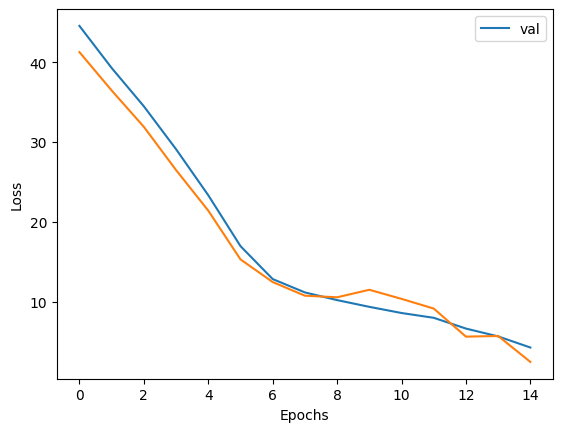

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 2
Epoch n0




1it [00:03,  3.22s/it]

2it [00:06,  3.15s/it]

3it [00:09,  3.16s/it]

4it [00:12,  3.22s/it]

5it [00:16,  3.26s/it]

6it [00:19,  3.29s/it]

7it [00:22,  3.32s/it]

8it [00:26,  3.33s/it]

9it [00:29,  3.36s/it]

10it [00:32,  3.34s/it]

11it [00:36,  3.35s/it]

12it [00:39,  3.36s/it]

13it [00:43,  3.37s/it]

14it [00:46,  3.43s/it]

15it [00:50,  3.35s/it]


0it [00:00, ?it/s]

TOTAL TRAIN LOSS 46.36526425679525




1it [00:01,  1.99s/it]

2it [00:04,  2.04s/it]

  7%|▋         | 1/15 [00:54<12:41, 54.37s/it]

0it [00:00, ?it/s]

2it [00:00, 12.66it/s]

TOTAL EVAL LOSS 43.85599613189697
TRAIN 	50.26697897911072 secs
TRAIN accuracy : 0.0
EVAL 	4.077505111694336 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




4it [00:00, 13.15it/s]

6it [00:00, 12.92it/s]

8it [00:00, 13.34it/s]

10it [00:00,  9.99it/s]

12it [00:01, 10.75it/s]

15it [00:01, 11.89it/s]


2it [00:00, 41.64it/s][A

 13%|█▎        | 2/15 [00:55<08:19, 38.46s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 42.08894077936808
TOTAL EVAL LOSS 38.99579167366028
TRAIN 	1.2626397609710693 secs
TRAIN accuracy : 0.0025380710659898475
EVAL 	0.049105167388916016 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n2




2it [00:00, 14.31it/s]

4it [00:00, 14.39it/s]

6it [00:00, 13.73it/s]

8it [00:00, 13.49it/s]

10it [00:00,  9.97it/s]

12it [00:01, 10.71it/s]

15it [00:01, 11.84it/s]


2it [00:00, 42.36it/s][A

 20%|██        | 3/15 [00:57<05:27, 27.32s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 38.31567653020223
TOTAL EVAL LOSS 36.16797208786011
TRAIN 	1.2682240009307861 secs
TRAIN accuracy : 0.04568527918781726
EVAL 	0.04828691482543945 secs
EVAL accuracy : 0.07846715328467153


** ** * Saving fine - tuned model ** ** * 
Epoch n3




2it [00:00, 13.74it/s]

4it [00:00, 13.93it/s]

6it [00:00, 13.35it/s]

8it [00:00, 13.37it/s]

10it [00:00,  9.92it/s]

12it [00:01, 10.49it/s]

15it [00:01, 11.67it/s]


2it [00:00, 41.35it/s][A

 27%|██▋       | 4/15 [00:58<03:34, 19.53s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 33.809810956319176
TOTAL EVAL LOSS 31.87320828437805
TRAIN 	1.2861509323120117 secs
TRAIN accuracy : 0.1065989847715736
EVAL 	0.04954075813293457 secs
EVAL accuracy : 0.10218978102189781


** ** * Saving fine - tuned model ** ** * 
Epoch n4




2it [00:00, 14.05it/s]

4it [00:00, 13.81it/s]

6it [00:00, 13.22it/s]

8it [00:00, 13.36it/s]

10it [00:00, 10.04it/s]

12it [00:01, 10.64it/s]

15it [00:01, 11.63it/s]


2it [00:00, 40.30it/s][A

 33%|███▎      | 5/15 [00:59<02:20, 14.08s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 29.34308910369873
TOTAL EVAL LOSS 26.523622274398804
TRAIN 	1.291384220123291 secs
TRAIN accuracy : 0.12436548223350254
EVAL 	0.05072474479675293 secs
EVAL accuracy : 0.10583941605839416


** ** * Saving fine - tuned model ** ** * 
Epoch n5




2it [00:00, 13.10it/s]

4it [00:00, 13.27it/s]

6it [00:00, 12.76it/s]

8it [00:00, 13.01it/s]

9it [00:00,  8.01it/s]

11it [00:01,  8.84it/s]

13it [00:01,  9.72it/s]

15it [00:01, 11.38it/s]


2it [00:00, 40.78it/s][A

 40%|████      | 6/15 [01:01<01:32, 10.27s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 24.484535773595173
TOTAL EVAL LOSS 21.080610752105713
TRAIN 	1.3192150592803955 secs
TRAIN accuracy : 0.1218274111675127
EVAL 	0.05020880699157715 secs
EVAL accuracy : 0.10401459854014598


** ** * Saving fine - tuned model ** ** * 
Epoch n6




2it [00:00, 12.73it/s]

4it [00:00, 13.16it/s]

6it [00:00, 12.88it/s]

8it [00:00, 12.94it/s]

9it [00:00,  7.99it/s]

11it [00:01,  8.92it/s]

13it [00:01,  9.81it/s]

15it [00:01, 11.50it/s]


2it [00:00, 38.46it/s][A

 47%|████▋     | 7/15 [01:02<01:00,  7.60s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 18.532419204711914
TOTAL EVAL LOSS 16.128525733947754
TRAIN 	1.3049101829528809 secs
TRAIN accuracy : 0.09644670050761421
EVAL 	0.05304694175720215 secs
EVAL accuracy : 0.11313868613138686


** ** * Saving fine - tuned model ** ** * 
Epoch n7




2it [00:00, 13.41it/s]

4it [00:00, 13.36it/s]

6it [00:00, 12.87it/s]

8it [00:00, 12.81it/s]

9it [00:00,  7.81it/s]

11it [00:01,  8.69it/s]

13it [00:01,  9.62it/s]

15it [00:01, 11.12it/s]


2it [00:00, 34.34it/s][A

 53%|█████▎    | 8/15 [01:03<00:40,  5.75s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 14.354999780654907
TOTAL EVAL LOSS 13.331412672996521
TRAIN 	1.3497388362884521 secs
TRAIN accuracy : 0.1116751269035533
EVAL 	0.05942821502685547 secs
EVAL accuracy : 0.10401459854014598


** ** * Saving fine - tuned model ** ** * 
Epoch n8




2it [00:00, 12.86it/s]

4it [00:00, 13.07it/s]

6it [00:00, 12.72it/s]

8it [00:00, 12.95it/s]

9it [00:00,  7.91it/s]

11it [00:01,  8.85it/s]

13it [00:01,  9.74it/s]

15it [00:01, 11.44it/s]


2it [00:00, 40.90it/s][A

 60%|██████    | 9/15 [01:05<00:26,  4.44s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 11.489587704340616
TOTAL EVAL LOSS 9.500527679920197
TRAIN 	1.312593936920166 secs
TRAIN accuracy : 0.1319796954314721
EVAL 	0.04997897148132324 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n9




2it [00:00, 13.71it/s]

4it [00:00, 13.91it/s]

6it [00:00, 13.42it/s]

8it [00:00, 13.67it/s]

10it [00:00, 10.07it/s]

12it [00:01, 10.74it/s]

15it [00:01, 11.90it/s]


2it [00:00, 40.78it/s][A

 67%|██████▋   | 10/15 [01:06<00:17,  3.50s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 9.785056789716085
TOTAL EVAL LOSS 9.681882858276367
TRAIN 	1.2620820999145508 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.05013084411621094 secs
EVAL accuracy : 0.14963503649635038


Epoch n10




2it [00:00, 13.80it/s]

4it [00:00, 13.98it/s]

6it [00:00, 13.54it/s]

8it [00:00, 13.79it/s]

10it [00:00,  9.96it/s]

12it [00:01, 10.65it/s]

15it [00:01, 11.83it/s]


2it [00:00, 39.38it/s][A

 73%|███████▎  | 11/15 [01:07<00:11,  2.85s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 8.597739319006601
TOTAL EVAL LOSS 8.569563031196594
TRAIN 	1.269345998764038 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.05184793472290039 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n11




2it [00:00, 14.09it/s]

4it [00:00, 14.18it/s]

6it [00:00, 13.57it/s]

8it [00:00, 13.38it/s]

10it [00:00,  9.89it/s]

12it [00:01, 10.67it/s]

15it [00:01, 11.74it/s]


2it [00:00, 41.33it/s][A

 80%|████████  | 12/15 [01:09<00:07,  2.40s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 7.4720691839853925
TOTAL EVAL LOSS 5.415187478065491
TRAIN 	1.2783539295196533 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.0494999885559082 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n12




2it [00:00, 14.07it/s]

4it [00:00, 14.30it/s]

6it [00:00, 13.74it/s]

8it [00:00, 13.79it/s]

10it [00:00, 10.01it/s]

12it [00:01, 10.70it/s]

15it [00:01, 11.90it/s]


2it [00:00, 41.60it/s][A

 87%|████████▋ | 13/15 [01:10<00:04,  2.08s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 6.153044561545054
TOTAL EVAL LOSS 5.51902174949646
TRAIN 	1.2613489627838135 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.049250125885009766 secs
EVAL accuracy : 0.14963503649635038


Epoch n13




2it [00:00, 13.99it/s]

4it [00:00, 14.09it/s]

6it [00:00, 13.10it/s]

8it [00:00, 13.45it/s]

10it [00:00,  9.85it/s]

12it [00:01, 10.38it/s]

15it [00:01, 11.43it/s]


2it [00:00, 42.52it/s][A

 93%|█████████▎| 14/15 [01:12<00:01,  1.87s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 4.9165984988212585
TOTAL EVAL LOSS 2.907649278640747
TRAIN 	1.3139839172363281 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.048120975494384766 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n14




2it [00:00, 14.01it/s]

4it [00:00, 14.05it/s]

6it [00:00, 13.48it/s]

8it [00:00, 13.54it/s]

10it [00:00,  9.97it/s]

12it [00:01, 10.74it/s]

15it [00:01, 11.84it/s]


2it [00:00, 42.35it/s][A

100%|██████████| 15/15 [01:13<00:00,  4.89s/it]


TOTAL TRAIN LOSS 2.5542798191308975
TOTAL EVAL LOSS 0.6677091866731644
TRAIN 	1.2681808471679688 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.04832792282104492 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 


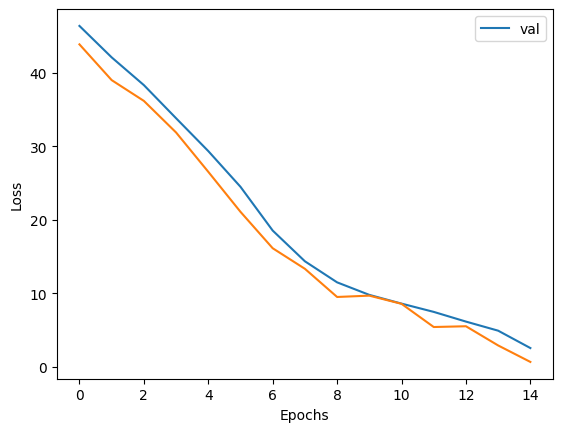

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 3
Epoch n0




1it [00:03,  3.56s/it]

2it [00:07,  3.57s/it]

3it [00:08,  2.89s/it]

4it [00:12,  3.13s/it]

5it [00:15,  3.29s/it]

6it [00:19,  3.39s/it]

7it [00:22,  3.41s/it]

8it [00:26,  3.51s/it]

9it [00:30,  3.60s/it]

10it [00:34,  3.68s/it]

11it [00:38,  3.72s/it]

12it [00:41,  3.76s/it]

13it [00:47,  3.68s/it]
 40%|████      | 2/5 [03:10<04:45, 95.30s/it]


KeyboardInterrupt: 

In [22]:
df = experiment(num_experiments=5)

In [22]:
df

,Experiment,Model,Metric,Score
0,1,GT_BERT,Val Accuracy,0.147826
1,1,GT_BERT,Train Loss,0.000004
2,1,GT_BERT,Val Loss,0.000000
3,1,GT_BERT,Train Time,76.409270
4,1,GT_BERT,Val Time,3.805819
5,2,GT_BERT,Val Accuracy,0.150000
6,2,GT_BERT,Train Loss,0.000001
7,2,GT_BERT,Val Loss,0.000000
8,2,GT_BERT,Train Time,75.925956
9,2,GT_BERT,Val Time,4.217366


In [23]:
# Group by Model and Metric and calculate average and standard deviation
result_df = df.groupby(['Model', 'Metric']).agg({'Score': ['mean', 'std']}).reset_index()

# Rename columns for clarity
result_df.columns = ['Model', 'Metric', 'Average Score', 'Standard Deviation']

result_df['Average Score'] = result_df['Average Score'].round(2)
result_df['Standard Deviation'] = result_df['Standard Deviation'].round(2)

# save the result
result_df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results_pretraining_1_global.csv')

In [24]:
 # print results
result_df

,Model,Metric,Average Score,Standard Deviation
0,GT_BERT,Train Loss,0.00,0.00
1,GT_BERT,Train Time,78.34,4.66
2,GT_BERT,Val Accuracy,0.15,0.00
3,GT_BERT,Val Loss,0.00,0.00
4,GT_BERT,Val Time,4.35,0.46
